# Fragility Algorithm - Cross Validation Study with Interictal Data

Here, we are interested in looking at how neural fragility can be used as a feature representation to assist in interpreting EEG data for the purposes of i) interictal SOZ localization and ii) interictal prediction of outcome.

Now, the reader is reminded that the true EZ is never observed in data. Therefore the clinical SOZ is only a heuristic estimate based on current clinical knowledge. Outcomes however, are observed (albeit outcome measures are somewhat subjective). 

Here, we pose the problem: Can a classification model predict surgical outcome conditioned on the clinical SOZ?

If you have a feature representation that you hypothesize correlates with the true EZ, then you would expect the classification model to be able to predict outcome well.

Under this framework, if it predicts success, then it implies the clinical SOZ correlates with your feature representation.

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    ShuffleSplit,
    cross_validate,
)
from sklearn.utils import resample

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from eztrack import read_clinical_excel
from eztrack.io import read_derivative_npy

# from rerf.rerfClassifier import rerfClassifier
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
class NumpyEncoder(json.JSONEncoder):
    """Special json encoder for numpy types.

    Pass to json.dump(), or json.load().
    """

    def default(self, obj):  # noqa
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):  # This is the fix
            return obj.tolist()
        elif isinstance(obj, (datetime, date)):
            return obj.isoformat()
        return json.JSONEncoder.default(self, obj)

In [4]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

# Define Functions to Get XY data

In [5]:
# comment if you don't have nb_black installed
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [6]:
def get_Xy_vector(dataset, feature_set, threshold):
    # create X, y pair for training
    X = []
    y = []
    engels = []
    ilaes = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        #         if subject.startswith("pt"):
        #             subject = "kumc" + subject.split("pt")[1]
        #         elif subject.isnumeric():
        #             subject = "rns" + subject

        # get the metadata
        soz_chs = dataset["soz_chs"][idx]
        ch_names = dataset["ch_names"][idx]
        soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
        nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

        # compute quantiles in each
        qtiles = np.linspace(0.1, 1.0, 3)

        X_buff = []
        for feature_name in feature_set:
            # get the data
            feature_map = dataset[feature_name][idx].copy()

            # set threshold
            if threshold is not None:
                feature_map[feature_map < threshold] = 0.0

            # stratify data into two sets of signals
            soz_feat = feature_map[soz_inds]
            nsoz_feat = feature_map[nsoz_inds]

            if len(soz_inds) == 0:
                print(subject, feature_name)
                raise Exception(
                    f"ERror with this person {subject} {soz_chs} {ch_names}"
                )

            #             print(soz_feat.shape, nsoz_feat.shape, feature_map.shape)
            #             print(np.std(soz_feat, axis=0).shape)
            # average over time
            soz_feat = np.mean(soz_feat, axis=0)
            nsoz_feat = np.mean(nsoz_feat, axis=0)

            # create a time-varying quantile heatmap
            soz_quant_map = np.vstack(
                [np.quantile(soz_feat, q=q) for q in qtiles]
            ).squeeze()
            nsoz_quant_map = np.vstack(
                [np.quantile(nsoz_feat, q=q) for q in qtiles]
            ).squeeze()

            #             print(soz_quant_map.shape, nsoz_quant_map.shape)
            new_data_feat = np.hstack(
                (
                    np.mean(soz_feat),
                    #                     np.std(soz_feat, axis=0).squeeze(),
                    soz_quant_map,
                    #                     np.median(soz_feat),
                    #                     np.median(nsoz_feat),
                    np.mean(nsoz_feat),
                    #                     np.std(nsoz_feat, axis=0).squeeze(),
                    nsoz_quant_map,
                    #                     np.mean(soz_feat) - np.mean(nsoz_feat),
                )
            )
            #             print(subject, np.max(new_data_feat))
            #             print(new_data_feat.shape)
            #             new_data_feat = np.mean(new_data_feat, axis=1, keepdims=True)
            X_buff.extend(new_data_feat.tolist())

        # convert buffer to numpy array for feature vector
        X_buff = np.array(X_buff)

        # get metadata
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
        ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]

        if outcome == "NR":
            continue

        X.append(X_buff)
        y.append(outcome)
        engels.append(engel)
        ilaes.append(ilae)
        subjects.append(subject)

    return X, y, subjects

# Setup Data Directory

In [7]:
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "extraoperative"
task = "interictal"
reference = "average"
deriv_chain = Path("originalsampling/fragility") / reference

deriv_path = deriv_root / deriv_chain

In [8]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

In [9]:
subjects = natsorted(get_entity_vals(deriv_path, "subject"))
print(subjects)
print(len(subjects))

['NIH1', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH6', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'PY18N002', 'PY18N007', 'PY18N013', 'PY18N015', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N026', 'jh103', 'jh105', 'kumc1', 'kumc2', 'kumc3', 'kumc4', 'kumc5', 'kumc6', 'kumc7', 'kumc8', 'kumc9', 'kumc10', 'kumc11', 'kumc12', 'kumc13', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl02', 'nl03', 'nl04', 'nl05', 'nl06', 'nl07', 'nl08', 'nl11', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt2', 'pt3', 'rns002', 'rns003', 'rns004', 'rns005', 'rns006', 'rns009', 'rns011', 'rns013', 'rns014', 'rns015', 'tvb1', 'tvb2', 'tvb7', 'tvb8', 'tvb12', 'tvb14', 'tvb17', 'tvb18', 'tvb19', 'tvb23', 'tvb27', 'tvb28', 'tvb29', 'umf001', 'umf002', 'umf003', 'umf004', 'umf005', 'upmc1', 'upmc2', 'upmc3', 'upmc4', 'upmc5', 'upmc6']
106


## Obtain Labels Using Excel Sheet

In [10]:
meta_df = pd.read_excel(meta_fpath)

display(meta_df.head(2))

,org_patientid,patient_id,number_datasets,clinical_center,modality,sfreq,previous_surgery?,clinical_complexity,engel_score,ilae_score,...,epilepsy_type,mri_outcome,postop_progress_info,date_of_recording,date_of_surgery,date_of_last_follow_up,years_follow_up,engel_class_full,notes,Unnamed: 38
0,NaN,la01,1,cc,seeg,1000,"Y (SEEG implant 4/2013, craniotomy 4/2013)",4,4,4.0,...,Multi-Focal,Normal,Seizure free since surgery.,2013-04-10 02:11:44,2014-01-01 00:00:00,2019-10-01 00:00:00,5,NaN,NaN,NaN
1,NaN,la02,1,cc,seeg,1000,VNS implant 4/24/2014,1,1,1.0,...,Focal,Normal,Seizure free since surgery.,NaN,2015-02-01 00:00:00,2018-11-01 00:00:00,3,NaN,PPT says: Lesion?,NaN


# Obtain Fragility Data From Each File

In [11]:
dataset = collections.defaultdict(list)

for subject in subjects:
    subj_dir = deriv_path / f"sub-{subject}"
    fpaths = subj_dir.glob("*desc-perturbmatrix*.npy")
    for idx, fpath in enumerate(fpaths):
        data_path = BIDSPath(
            subject=subject,
            session=session,
            task=task,
            #             acquisition=acquisition,
            run=idx + 1,
            suffix="desc-perturbmatrix_ieeg",
            extension=".npy",
            check=False,
        )

        deriv = read_derivative_npy(fpath, source_check=False)
        deriv.load_data()
        deriv.normalize()
        ch_names = deriv.ch_names

        # read in the dataframe of clinical datasheet
        #         if subject.startswith("pt"):
        #             subject = "kumc" + subject.split("pt")[1]
        #         elif subject.isnumeric():
        #             subject = "rns" + subject
        pat_dict = read_clinical_excel(meta_fpath, subject=subject)

        # get the SOZ channels for this subject
        soz_chs = pat_dict["SOZ_CONTACTS"]
        frag_mat = deriv.get_data()

        dataset["subject"].append(subject)
        dataset["frag_mat"].append(frag_mat)
        dataset["ch_names"].append(ch_names)
        dataset["soz_chs"].append(soz_chs)

#         break

#     break

In [12]:
print(frag_mat.shape)

(92, 4855)


In [13]:
feature_name = ["frag_mat"]
X, y, subjects = get_Xy_vector(dataset, feature_name, threshold=None)

In [14]:
X = np.array(X).squeeze()
y = np.array(y).squeeze()
subjects = np.array(subjects)
y = enc.fit_transform(y[:, np.newaxis]).squeeze()

# print(new_data_feat.shape)
print(X.shape)
print(y.shape)
print(subjects.shape)
print(y)

(113, 8)
(113,)
(113,)
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.]


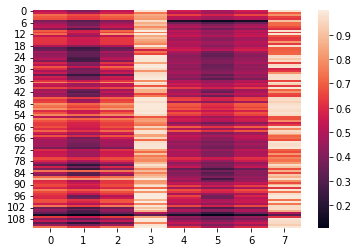

In [15]:
sns.heatmap(X)
plt.show()

# Define Cross Validation Function

In [16]:
n_splits = 10
train_size = 0.8
random_state = 12345

subject_groups = np.array(subjects)

In [17]:
cv = StratifiedShuffleSplit(
    n_splits=n_splits, train_size=train_size, random_state=random_state
)

# Run Classification Validation Pipeline

In [27]:
print(subjects)

['NIH1' 'NIH2' 'NIH3' 'NIH4' 'NIH5' 'NIH6' 'NIH7' 'NIH8' 'NIH9' 'NIH10'
 'NIH11' 'PY18N002' 'PY18N007' 'PY18N013' 'PY18N015' 'PY19N012' 'PY19N015'
 'PY19N023' 'PY19N026' 'jh103' 'jh103' 'jh105' 'jh105' 'kumc1' 'kumc2'
 'kumc3' 'kumc4' 'kumc5' 'kumc6' 'kumc7' 'kumc8' 'kumc9' 'kumc10' 'kumc11'
 'kumc12' 'kumc13' 'la01' 'la02' 'la03' 'la04' 'la05' 'la06' 'la07' 'la08'
 'la09' 'la10' 'la11' 'la13' 'la15' 'la16' 'la21' 'la22' 'la23' 'la24'
 'nl01' 'nl03' 'nl04' 'nl05' 'nl07' 'nl08' 'nl12' 'nl13' 'nl14' 'nl15'
 'nl16' 'nl18' 'nl19' 'nl20' 'pt1' 'pt1' 'pt1' 'pt1' 'pt2' 'pt2' 'pt2'
 'pt2' 'pt3' 'pt3' 'pt3' 'rns002' 'rns003' 'rns004' 'rns005' 'rns006'
 'rns009' 'rns011' 'rns013' 'rns014' 'rns015' 'tvb1' 'tvb2' 'tvb7' 'tvb8'
 'tvb12' 'tvb14' 'tvb17' 'tvb18' 'tvb19' 'tvb23' 'tvb27' 'tvb28' 'tvb29'
 'umf001' 'umf002' 'umf003' 'umf004' 'umf005' 'upmc1' 'upmc2' 'upmc3'
 'upmc4' 'upmc5' 'upmc6']


In [18]:
n_features = X.shape[1]
model_params = {
    #     "projection_matrix": "RerF",
    "n_estimators": 2000,
    "max_features": n_features * 2,
    "n_jobs": -1,
    "random_state": random_state,
}


# model_params["projection_matrix"] = "S-RerF"
# model_params["image_height"] = 24
# model_params["image_width"] = 30


# clf = rerfClassifier(**model_params)
clf = ObliqueForestClassifier(**model_params)
# clf = RandomForestClassifier(**model_params)

In [19]:
# perform CV using Sklearn
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    #     groups=subject_groups,
    #     cv=zip(train_index, test_index),
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
)

In [20]:
# get the estimators
estimators = scores.pop("estimator")

print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_subjects",
    "test_subjects",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]
    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

Using estimator  ObliqueForestClassifier(max_features=16, n_estimators=2000, n_jobs=-1,
                        random_state=12345)


In [21]:
fname = deriv_root / f"cv{n_splits}_exp_{feature_name[0]}.json"
print(fname)

/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal/derivatives/cv10_exp_frag_mat.json


In [142]:
with open(fname.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

# Make Plots of the Data

In [143]:
scores = feature_scores

NameError: name 'feature_scores' is not defined

In [22]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [23]:
print(np.mean(aucs), np.std(aucs))

0.5053030303030303 0.07392091795986698


In [24]:
metric = "test_balanced_accuracy"
print(np.mean(scores[metric]), "+/-", np.std(scores[metric]))

0.5140151515151515 +/- 0.06470623913441509


## Making ROC Curve With Confidence Interval

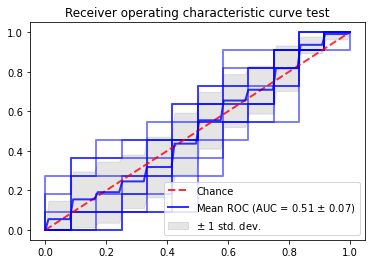

In [25]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set}",
)
ax.legend(loc="lower right")
plt.show()